In [224]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.spatial.distance import cosine, euclidean

In [225]:
TRAIN_PAIRS_PATH = "../dataset/train_pairs.parquet"
TRAIN_DATA_PATH = "../dataset/train_data.parquet"

In [226]:
train_pairs = pd.read_parquet(TRAIN_PAIRS_PATH)
train_etl = pd.read_parquet(TRAIN_DATA_PATH)

In [227]:
train_etl['categories4'] = train_etl['categories'].apply(lambda x: json.loads(x)["4"])
train_etl['categories3'] = train_etl['categories'].apply(lambda x: json.loads(x)["3"])
train_etl['categories2'] = train_etl['categories'].apply(lambda x: json.loads(x)["2"])

In [228]:
train_etl['categories'] = train_etl['categories'].apply(lambda x: json.loads(x)["3"])
train_cat_counts = train_etl['categories'].value_counts()
train_etl['categories'] = train_etl['categories'].apply(lambda x: x if train_cat_counts[x] > 1000 else "rest")

In [229]:
def parse_values(row):
  if row is None:
    return "[SEP]"
  
  parsed_row = json.loads(row).values()
  parsed_row = " ".join([" ".join(val) for val in parsed_row])
  return parsed_row

def parse_keys(row):
  if row is None:
    return "[SEP]"
  
  parsed_row = json.loads(row).keys()
  parsed_row = " ".join([val for val in parsed_row])
  return parsed_row

In [230]:
train_etl["attr_keys"] = train_etl['characteristic_attributes_mapping'].apply(parse_keys)
train_etl["attr_vals"] = train_etl['characteristic_attributes_mapping'].apply(parse_values)

In [231]:
all_keys = []
for row in train_etl['characteristic_attributes_mapping']:
    if row is None:
        continue
    keys = list(json.loads(row).keys())
    for key in keys:
        if key not in all_keys:
            all_keys.append(key)
all_keys = ["variantid"] + all_keys

In [232]:
key_counts = {k : 0 for k in all_keys}
for row in train_etl['characteristic_attributes_mapping']:
    if row is None:
        continue
    keys = list(json.loads(row).keys())
    for key in keys:
        key_counts[key] +=1

In [233]:
sorted_keys_counts = {k: v for k, v in sorted(key_counts.items(), key=lambda item: item[1], reverse=True)}

In [234]:
print(sorted_keys_counts)

{'Бренд': 456623, 'Тип': 375463, 'Цвет товара': 333347, 'Страна-изготовитель': 326584, 'Гарантийный срок': 282340, 'Вес товара, г': 233679, 'Комплектация': 221740, 'Размеры, мм': 158581, 'Название цвета': 111071, 'Диагональ экрана, дюймы': 107394, 'Оперативная память': 102840, 'Число ядер процессора': 102178, 'Бренд процессора': 97245, 'Процессор': 91489, 'Разрешение экрана': 91250, 'Бренд графического процессора': 89134, 'Модуль связи Bluetooth': 88900, 'Назначение': 88867, 'Модель процессора': 86840, 'Модуль связи WiFi': 85910, 'Особенности': 83225, 'Операционная система': 80579, 'Интерфейсы': 79946, 'Частота процессора, ГГц': 77489, 'Беспроводные интерфейсы': 73843, 'Технология матрицы': 73064, 'Тип памяти': 71623, 'Емкость аккумулятора, мАч': 69952, 'Защита от влаги': 65585, 'Основной материал корпуса': 63342, 'Тип жесткого диска': 58355, 'Навигация': 57130, 'Встроенные датчики': 54570, 'Число SIM-карт': 53616, 'Стандарты связи': 52913, 'Встроенная память': 52413, 'Рекомендовано дл

In [235]:
selected_keys = list(sorted_keys_counts.keys())[:30]
selected_keys = ["variantid"] + selected_keys

In [236]:
key_vals_dict = {k : [] for k in selected_keys}
for idx, row in train_etl[['variantid', 'characteristic_attributes_mapping']].iterrows():
    id = row['variantid']
    attrs = row['characteristic_attributes_mapping']

    if attrs is not None:
        attrs_dict = json.loads(attrs)
        attrs_dict = {k : v for k,v in attrs_dict.items()}         
    else:
        attrs_dict = {}

    attrs_dict['variantid'] = id

    for k in key_vals_dict.keys():
        v = None
        if k in attrs_dict.keys():
            v = attrs_dict[k]
            if type(v) is list:
                if len(v) == 1:
                    v = v[0]
                    v = int(v) if v.isdecimal() else v
                elif len(v) > 1:
                    v = " ".join(v)
                else:
                    v = None
        
        key_vals_dict[k].append(v) 

In [237]:
top_attrs_df = pd.DataFrame(key_vals_dict)
top_attrs_df.head(5)

,variantid,Бренд,Тип,Цвет товара,Страна-изготовитель,Гарантийный срок,"Вес товара, г",Комплектация,"Размеры, мм",Название цвета,...,Особенности,Операционная система,Интерфейсы,"Частота процессора, ГГц",Беспроводные интерфейсы,Технология матрицы,Тип памяти,"Емкость аккумулятора, мАч",Защита от влаги,Основной материал корпуса
0,51195767,Партнер-Электро,Удлинитель бытовой,оранжевый,Россия,None,1760,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,53565809,Baseus,Кабель,красный,Китай,6 месяцев,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,56763357,Konus,Аксессуар для микроскопа,None,None,2 года,None,Набор микропрепаратов Konus 25: «Беспозвоночны...,None,None,...,None,None,None,None,None,None,None,None,None,None
3,56961772,BQ,Мобильный телефон,черный,Китай,1,68,"Телефон,зарядное устройство",None,None,...,FM-радио,None,microUSB,None,Bluetooth,None,None,600,None,Пластик
4,61054740,Apiko,Штатив,черный,None,1 год,None,None,None,None,...,Возможность съемки панорам Съемная площадка Ур...,None,None,None,None,None,None,None,None,None


In [238]:
def show_attr_info(value_counts):

    X_axis = np.arange(len(value_counts))
    
    plt.bar(X_axis - 0.2, value_counts.values, 0.4)
    
    plt.xticks(X_axis, value_counts.index.to_list(), rotation=90)
    plt.xlabel(value_counts.index.name)
    plt.ylabel("Counts")
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


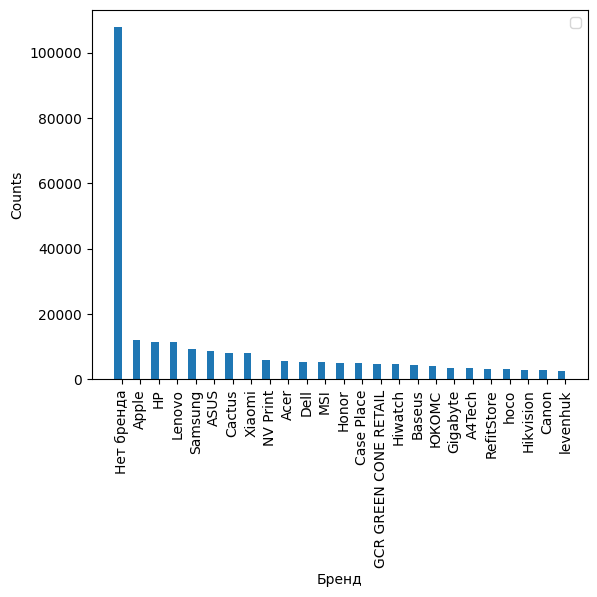

In [239]:
top_attrs_df['Бренд'] = top_attrs_df['Бренд'].fillna("Нет бренда")
show_attr_info(top_attrs_df['Бренд'].value_counts()[:25])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


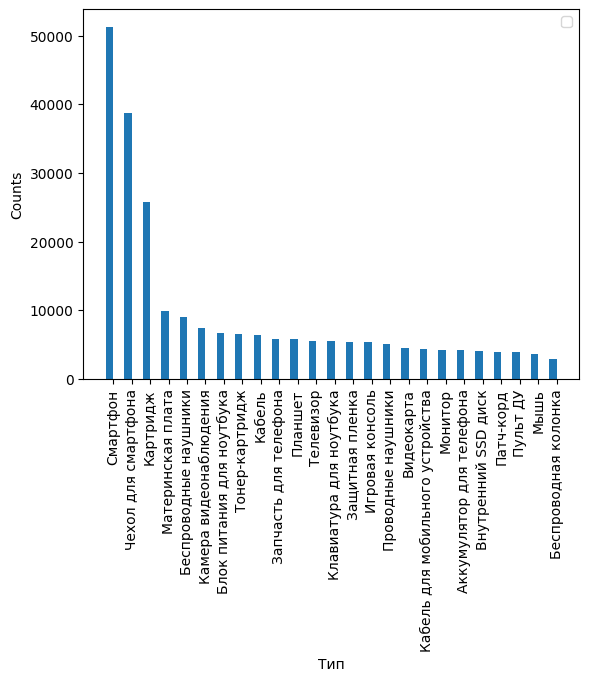

In [102]:
show_attr_info(top_attrs_df['Тип'].value_counts()[:25])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


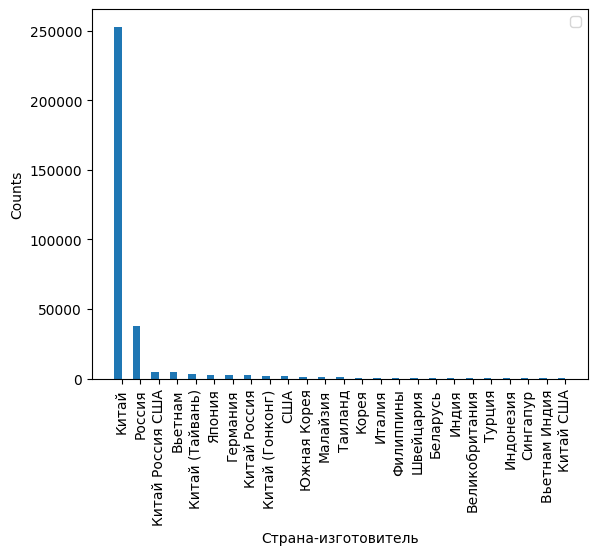

In [240]:
show_attr_info(top_attrs_df['Страна-изготовитель'].value_counts()[:25])

In [241]:
top_attrs_df.isna().sum().sum()/(top_attrs_df.shape[0]*top_attrs_df.shape[1])

0.6663390724776912

In [242]:
empty = top_attrs_df.isna().sum()/top_attrs_df.shape[0]
empty.head(25)

variantid                        0.000000
Бренд                            0.000000
Тип                              0.178531
Цвет товара                      0.270676
Страна-изготовитель              0.285473
Гарантийный срок                 0.382273
Вес товара, г                    0.488738
Комплектация                     0.514859
Размеры, мм                      0.653043
Название цвета                   0.756990
Диагональ экрана, дюймы          0.765035
Оперативная память               0.774998
Число ядер процессора            0.776447
Бренд процессора                 0.787239
Процессор                        0.799833
Разрешение экрана                0.800356
Бренд графического процессора    0.804985
Модуль связи Bluetooth           0.805497
Назначение                       0.805569
Модель процессора                0.810004
Модуль связи WiFi                0.812039
Особенности                      0.817914
Операционная система             0.823703
Интерфейсы                       0

In [243]:
train_etl = train_etl.drop(['pic_embeddings_resnet_v1', 'characteristic_attributes_mapping', 'color_parsed'], axis=1)

In [244]:
train_features = train_etl.merge(top_attrs_df, on='variantid')

In [245]:
train_features['Бренд'] = train_features['Бренд'].replace("Нет бренда", None)

In [246]:
train = (
    train_pairs
    .merge(
        train_features
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        train_features
        .add_suffix('2'),
        on="variantid2"
    )
)
train.head(1)

,target,variantid1,variantid2,name1,categories1,main_pic_embeddings_resnet_v11,name_bert_641,categories41,categories31,categories21,...,Особенности2,Операционная система2,Интерфейсы2,"Частота процессора, ГГц2",Беспроводные интерфейсы2,Технология матрицы2,Тип памяти2,"Емкость аккумулятора, мАч2",Защита от влаги2,Основной материал корпуса2
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"Сетевые фильтры, разветвители и удлинители","[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","Сетевой фильтр, удлинитель, разветвитель","Сетевые фильтры, разветвители и удлинители",Электроника,...,None,None,None,None,None,None,None,None,None,None


In [247]:
train_features.columns

Index(['variantid', 'name', 'categories', 'main_pic_embeddings_resnet_v1',
       'name_bert_64', 'categories4', 'categories3', 'categories2',
       'attr_keys', 'attr_vals', 'Бренд', 'Тип', 'Цвет товара',
       'Страна-изготовитель', 'Гарантийный срок', 'Вес товара, г',
       'Комплектация', 'Размеры, мм', 'Название цвета',
       'Диагональ экрана, дюймы', 'Оперативная память',
       'Число ядер процессора', 'Бренд процессора', 'Процессор',
       'Разрешение экрана', 'Бренд графического процессора',
       'Модуль связи Bluetooth', 'Назначение', 'Модель процессора',
       'Модуль связи WiFi', 'Особенности', 'Операционная система',
       'Интерфейсы', 'Частота процессора, ГГц', 'Беспроводные интерфейсы',
       'Технология матрицы', 'Тип памяти', 'Емкость аккумулятора, мАч',
       'Защита от влаги', 'Основной материал корпуса'],
      dtype='object')

In [248]:
text_cols = ['name', 'attr_vals','attr_keys','Интерфейсы',
             'Особенности', 
             'Комплектация', 'Назначение', 
             'Процессор',
            'Модуль связи WiFi']

num_cols = ['Гарантийный срок','Вес товара, г', 'Размеры, мм', 
            'Диагональ экрана, дюймы','Оперативная память',
              'Число ядер процессора', 'Разрешение экрана',
                'Частота процессора, ГГц', 'Емкость аккумулятора, мАч']

categorial_cols = ['categories4', 'categories2','categories3','Бренд', 'Тип',
                    'Цвет товара', 'Страна-изготовитель',
                    'Бренд процессора', 'Бренд графического процессора', 
                    'Название цвета', 'Процессор', 'Беспроводные интерфейсы',
                      'Модуль связи Bluetooth', 'Операционная система', 'Модель процессора', 
                      'Технология матрицы', 'Тип памяти', 'Защита от влаги', 'Основной материал корпуса']

emb_cols = ['name_bert_64', 'main_pic_embeddings_resnet_v1']

In [249]:
def get_cat_features(row):
    if row[0] is None or row[1] is None:
        return -1
    if row[0] == row[1]:
        return 1
    else:
        return 0

In [250]:
for cat_col in categorial_cols:

    cols = [f'{cat_col}1', f'{cat_col}2']
    train[f'same_{cat_col}'] = train[cols].apply(get_cat_features, axis=1)

for cat_col in num_cols:

    cols = [f'{cat_col}1', f'{cat_col}2']
    train[f'same_{cat_col}'] = train[cols].apply(get_cat_features, axis=1)

In [251]:
def jaccard_index(row):
    if row.iloc[0] is None or row.iloc[1] is None:
        return -1
    row1 = row.iloc[0]
    row2 = row.iloc[1]
    row1 = str(row1).lower().split()
    row2 = str(row2).lower().split()

    intersection = np.intersect1d(row1, row2)
    unioin = np.union1d(row1, row2)
    if len(intersection) == 0 or len(unioin) == 0:
        return 0

    return len(intersection) / len(unioin)

In [252]:
def overlap_coeff(row):
    if row.iloc[0] is None or row.iloc[1] is None:
        return -1
    
    row1 = row.iloc[0]
    row2 = row.iloc[1]
    row1 = str(row1).lower().split()
    row2 = str(row2).lower().split()

    intersection = np.intersect1d(row1, row2)
    minimum = np.min([len(row1), len(row2)])
                     
    if len(intersection) == 0 or minimum == 0 :
        return 0                     

    return len(intersection) /minimum

In [ ]:
# train['levi_names'] = train[['name1', 'name2']].apply(lambda x: edit_distance(x[0], x[1]), axis=1)
# train['levi_atr_keys'] = train[['attr_keys1', 'attr_keys2']].apply(lambda x: edit_distance(x[0], x[1]), axis=1)
# train['levi_atr_vals'] = train[['attr_vals1', 'attr_vals2']].apply(lambda x: edit_distance(x[0], x[1]), axis=1)

In [253]:
for cat_col in text_cols:

    cols = [f'{cat_col}1', f'{cat_col}2']
    train[f'jaccard_{cat_col}'] = train[cols].apply(jaccard_index, axis=1)
    train[f'overlap_{cat_col}'] = train[cols].apply(overlap_coeff, axis=1)

In [254]:
def cosine_sim(row):
    row1 = row.iloc[0]
    row2 = row.iloc[1]

    sim = cosine(row1, row2)
    return sim

def euclidean_sim(row):
    row1 = row.iloc[0]
    row2 = row.iloc[1]

    sim = euclidean(row1, row2)
    return sim

def dot_prod(row):
    row1 = row.iloc[0]
    row2 = row.iloc[1]

    return np.dot(row1, row2)

In [255]:
train['main_pic_embeddings_resnet_v11'] = train['main_pic_embeddings_resnet_v11'].apply(lambda x: x[0])
train['main_pic_embeddings_resnet_v12'] = train['main_pic_embeddings_resnet_v12'].apply(lambda x: x[0])

In [256]:
train['name_bert_dot'] = train[['name_bert_641', 'name_bert_642']].apply(dot_prod, axis=1)
train['name_bert_cos'] = train[['name_bert_641', 'name_bert_642']].apply(cosine_sim, axis=1)
train['name_bert_euc'] = train[['name_bert_641', 'name_bert_642']].apply(euclidean_sim, axis=1)

train['resnet_dot'] = train[['main_pic_embeddings_resnet_v11', 'main_pic_embeddings_resnet_v12']].apply(dot_prod, axis=1)
train['resnet_bert_cos'] = train[['main_pic_embeddings_resnet_v11', 'main_pic_embeddings_resnet_v12']].apply(cosine_sim, axis=1)
train['resnet_bert_euc'] = train[['main_pic_embeddings_resnet_v11', 'main_pic_embeddings_resnet_v12']].apply(euclidean_sim, axis=1)

In [257]:
for col in text_cols:
    if f"{col}1" in train.columns:
        cols = [f'{col}1', f'{col}2']
        train = train.drop(cols, axis=1)

for col in num_cols:
    if f"{col}1" in train.columns:
        cols = [f'{col}1', f'{col}2']
        train = train.drop(cols, axis=1)

for col in categorial_cols:
    if f"{col}1" in train.columns:
        cols = [f'{col}1', f'{col}2']
        train = train.drop(cols, axis=1)

for col in emb_cols:
    if f"{col}1" in train.columns:
        cols = [f'{col}1', f'{col}2']
        train = train.drop(cols, axis=1)

In [259]:
train = train.drop('categories2', axis=1)

In [260]:
train.head()

,target,variantid1,variantid2,categories1,same_categories4,same_categories2,same_categories3,same_Бренд,same_Тип,same_Цвет товара,...,jaccard_Процессор,overlap_Процессор,jaccard_Модуль связи WiFi,overlap_Модуль связи WiFi,name_bert_dot,name_bert_cos,name_bert_euc,resnet_dot,resnet_bert_cos,resnet_bert_euc
0,0.0,51197862,51198054,"Сетевые фильтры, разветвители и удлинители",1,1,1,1,1,1,...,-1.0,-1.0,-1.0,-1.0,15.188051,0.003606,0.338458,86.646202,0.000387,0.259265
1,0.0,51197862,51199884,"Сетевые фильтры, разветвители и удлинители",1,1,1,1,1,1,...,-1.0,-1.0,-1.0,-1.0,15.313345,0.007311,0.475419,86.537857,0.000456,0.282023
2,1.0,53062686,536165289,Расходник для печати,1,1,1,1,1,-1,...,-1.0,-1.0,-1.0,-1.0,15.343762,0.010588,0.577868,41.408783,0.012371,1.078670
3,1.0,53602615,587809782,Расходник для печати,1,1,1,-1,1,-1,...,-1.0,-1.0,-1.0,-1.0,15.981980,0.007455,0.491225,41.039062,0.011430,1.008816
4,1.0,53602615,615149925,Расходник для печати,1,1,1,1,1,-1,...,-1.0,-1.0,-1.0,-1.0,15.921898,0.006258,0.451149,40.977360,0.010815,0.985881


In [261]:
train.to_parquet("../preprocessed/generated_features.parquet", index=False)